# Color Analysis

In [1]:
from analyze import analyze_color_histogram
from scg_detection_tools.models import YOLO_NAS, YOLOv8
from scg_detection_tools.detect import Detector
from scg_detection_tools.utils.file_handling import read_yaml
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
import cv2

cfg = read_yaml("analyze_config.yaml")
#model = YOLOv8(yolov8_ckpt_path=cfg["yolov8_model_path"])
model = YOLO_NAS(model_arch=cfg["yolonas_arch"], 
                 checkpoint_path=cfg["yolonas_model_path"], 
                 classes=cfg["data_classes"])
det_params = cfg["detect_parameters"]
det_params["embed_slice_callback"] = None
det = Detector(detection_model=model, detection_params=det_params)


[2024-09-03 19:31:11] INFO - crash_tips_setup.py - Crash tips is enabled. You can set your environment variable to CRASH_HANDLER=FALSE to disable it


The console stream is logged into /home/julio/sg_logs/console.log


AttributeError: _ARRAY_API not found

SystemError: <built-in function __import__> returned a result with an exception set


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.1.0 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/home/julio/Dev/SCG_IFSC/venv/lib/python3.10/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/home/julio/Dev/SCG_IFSC/venv/lib/python3.10/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/home/julio/Dev/SCG_IFS

[WARNING]No module named 'pycocotools'


[2024-09-03 19:31:15] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/julio/Dev/SCG_IFSC/checkpoints/yolonas/large/train2/ckpt_best.pth EMA checkpoint.


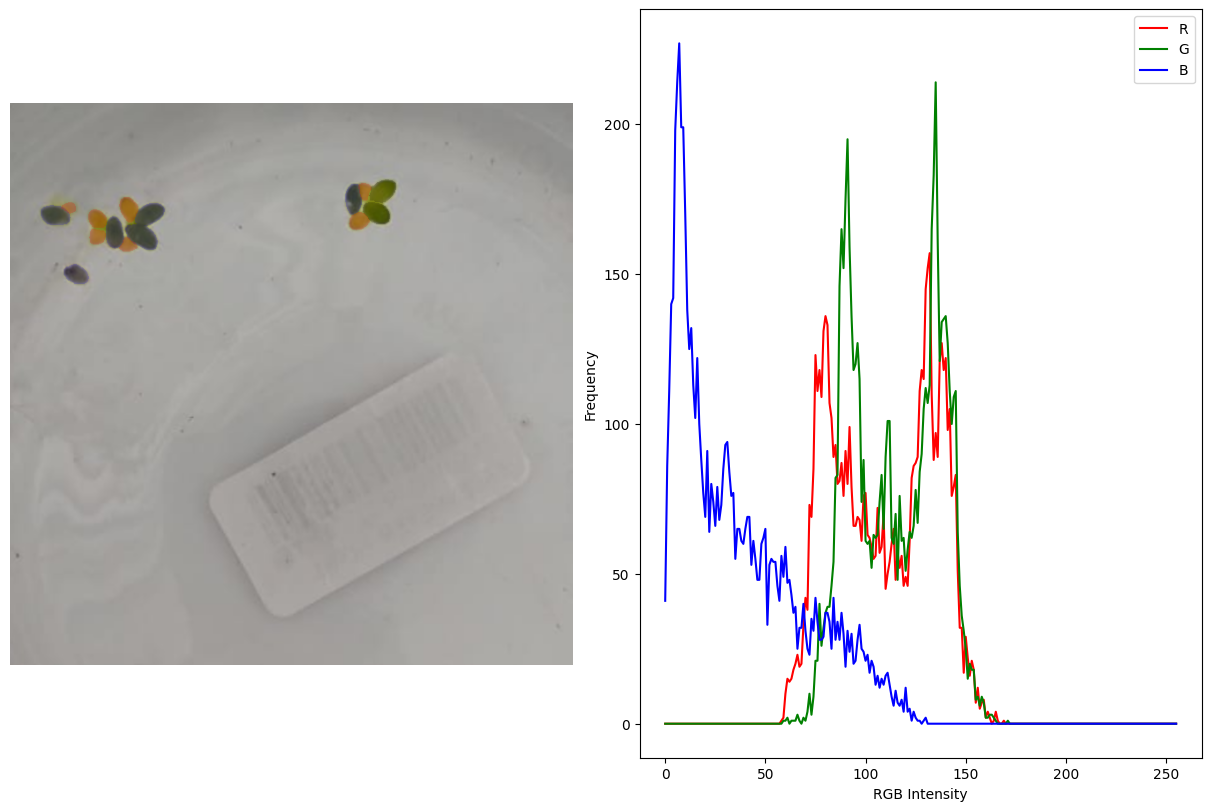

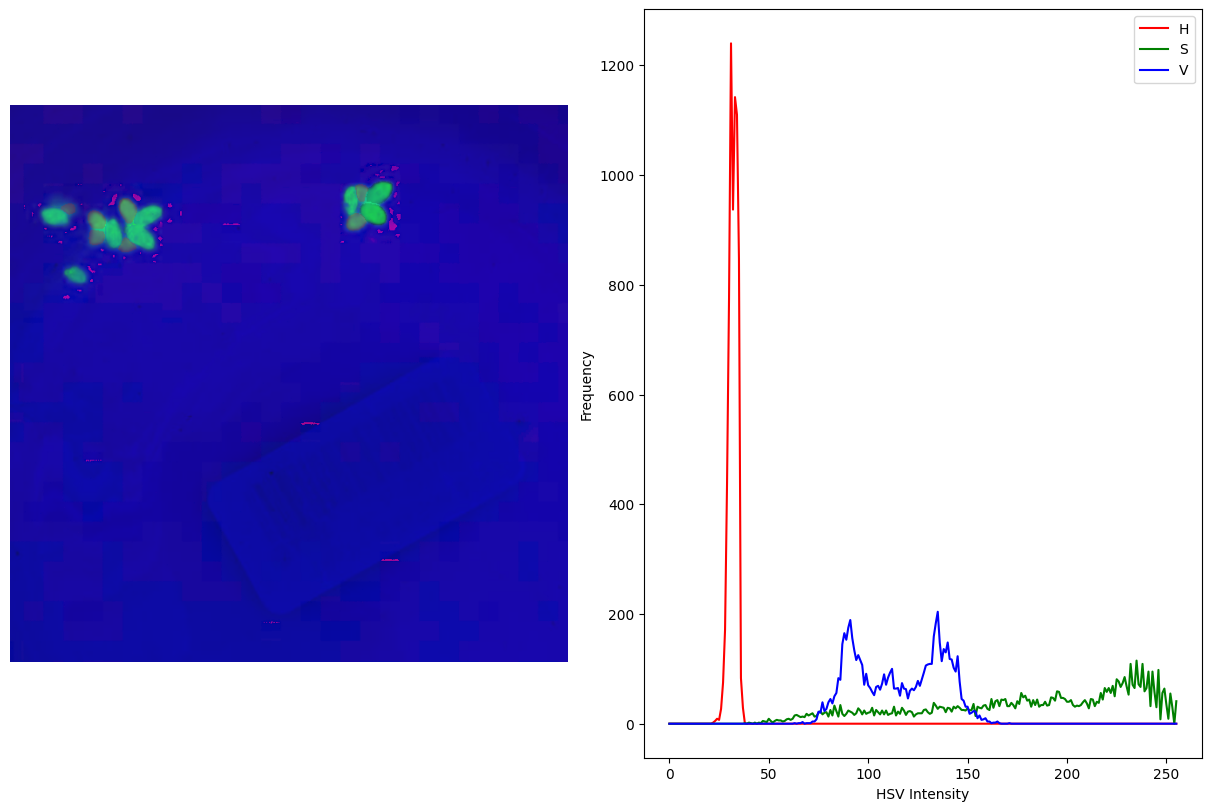

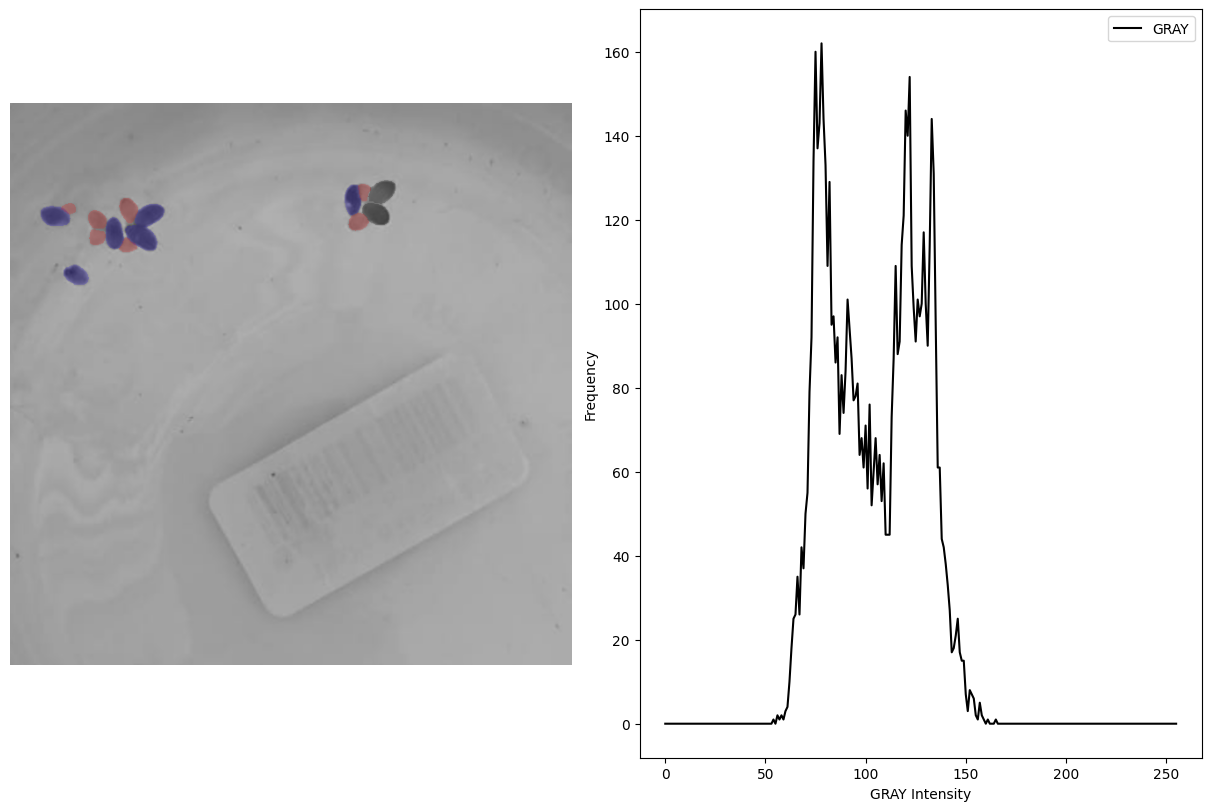

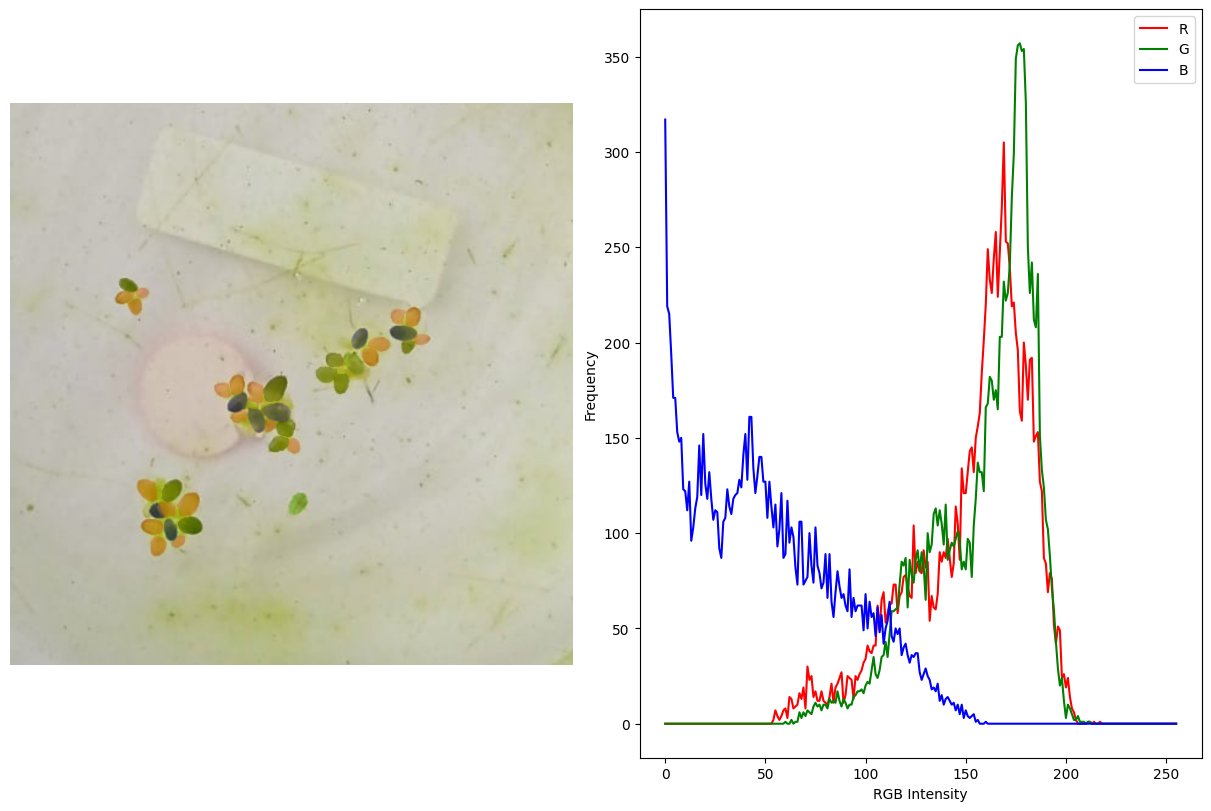

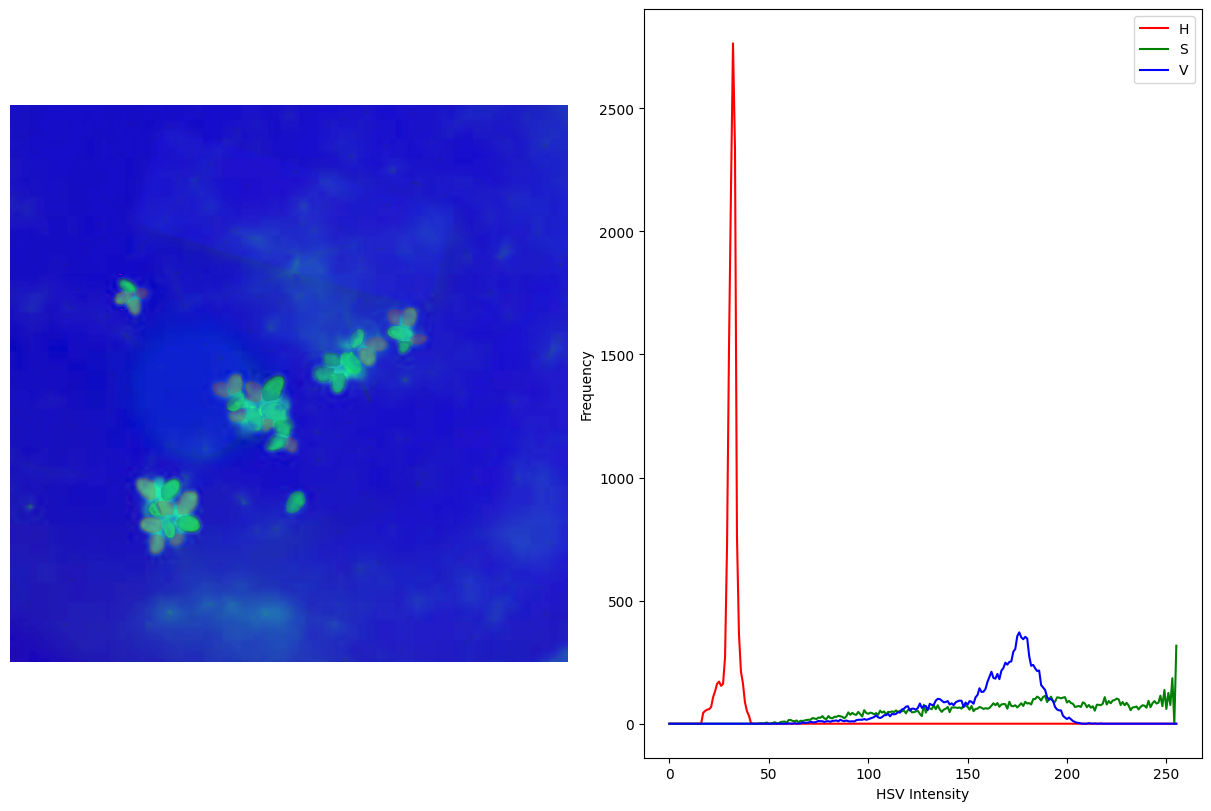

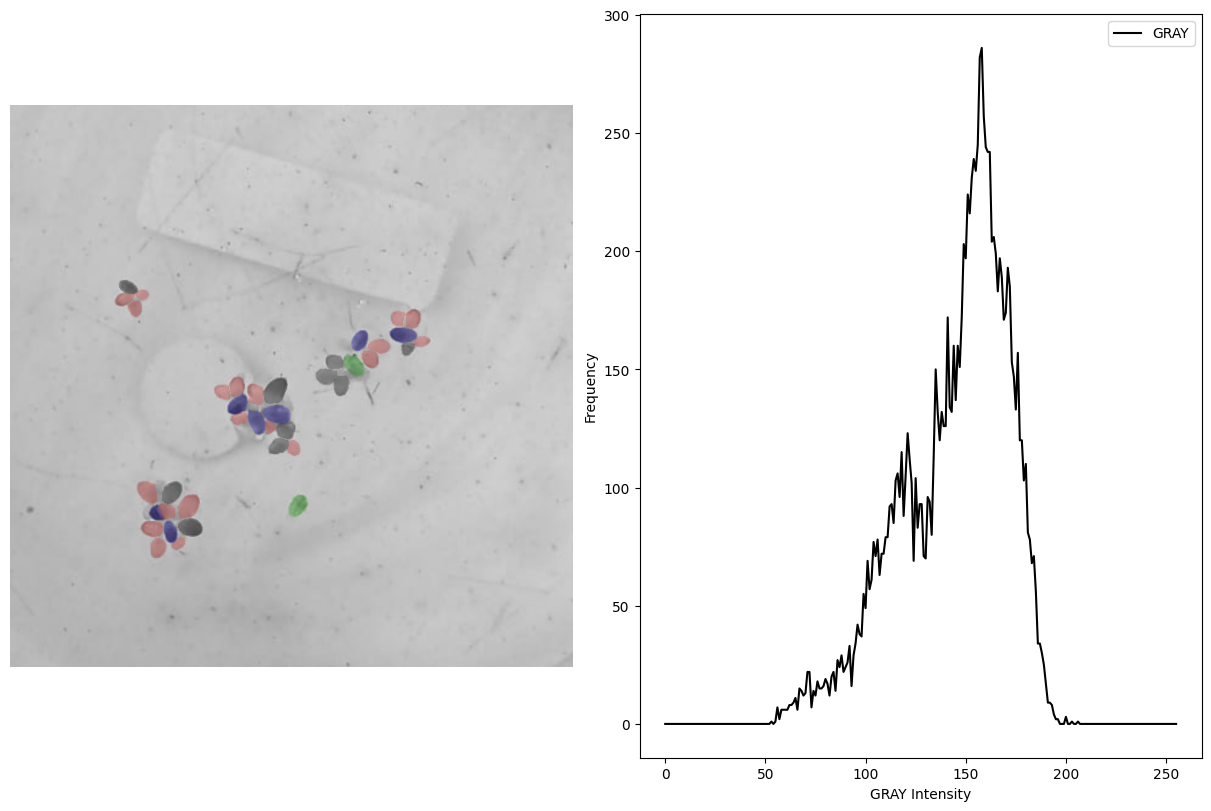

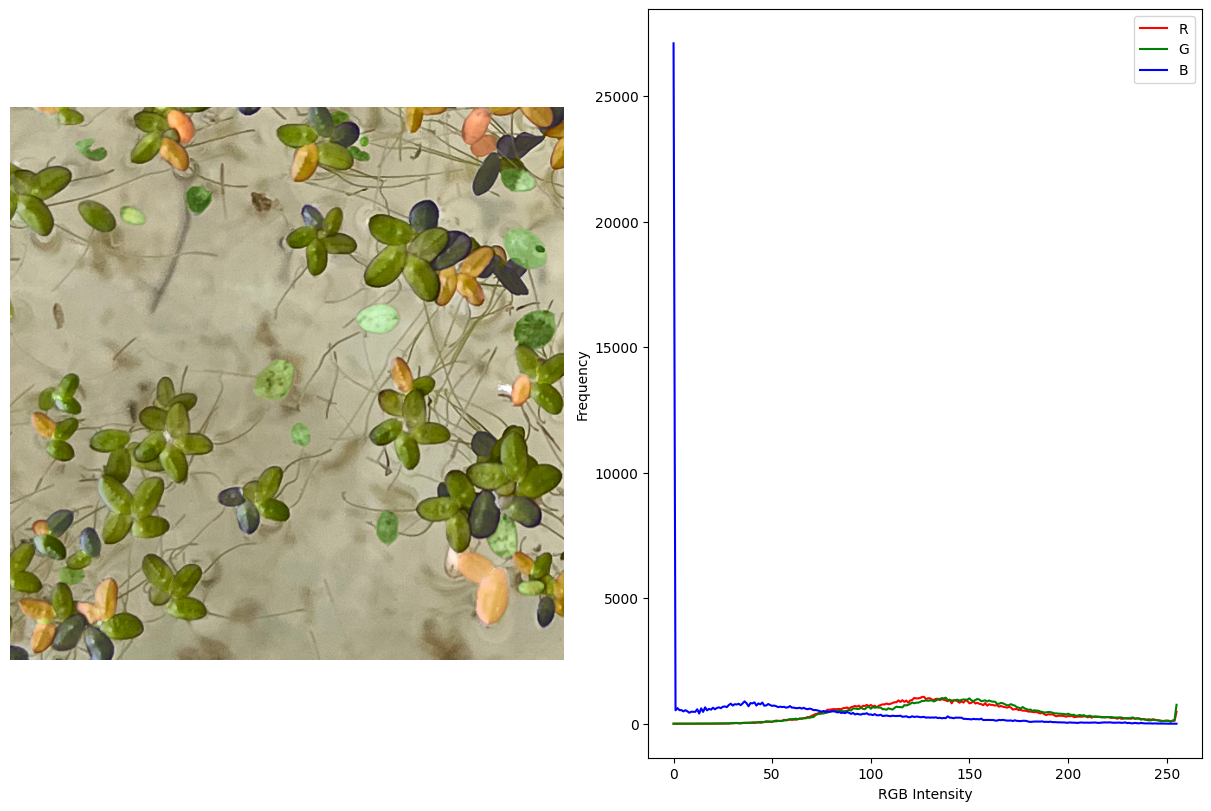

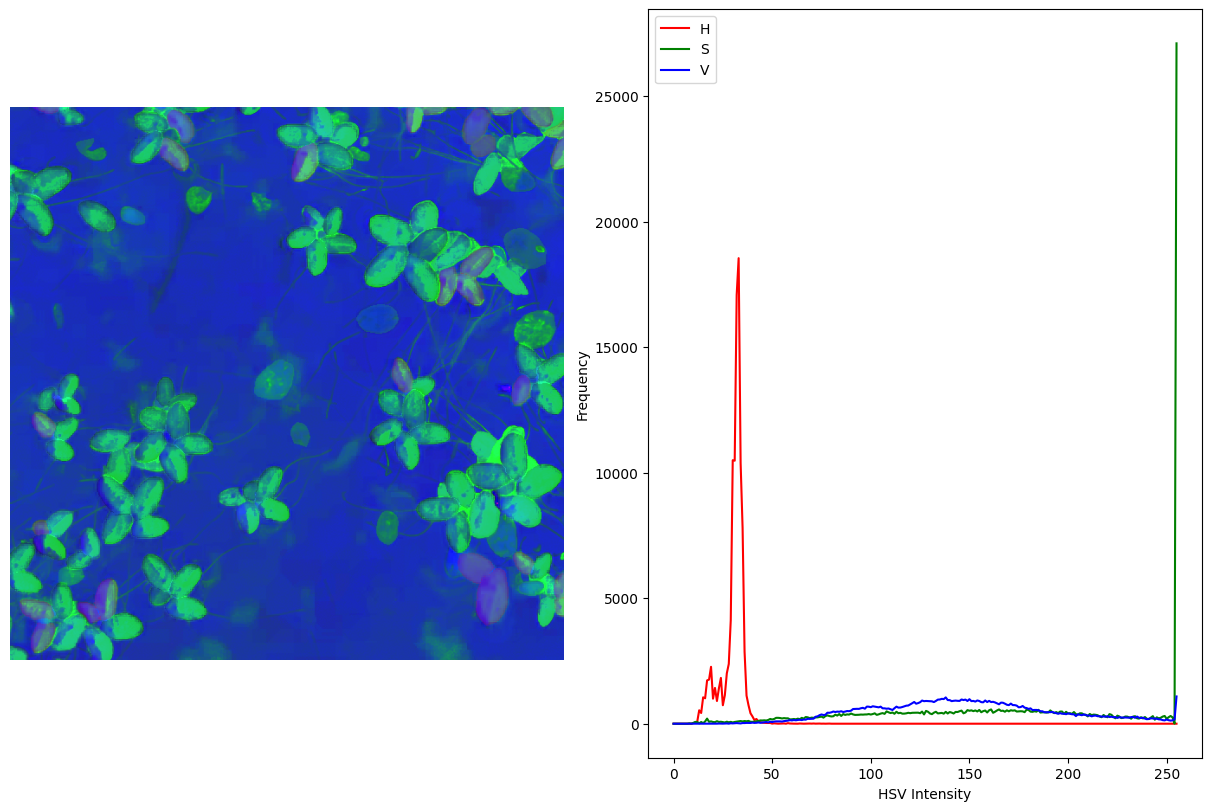

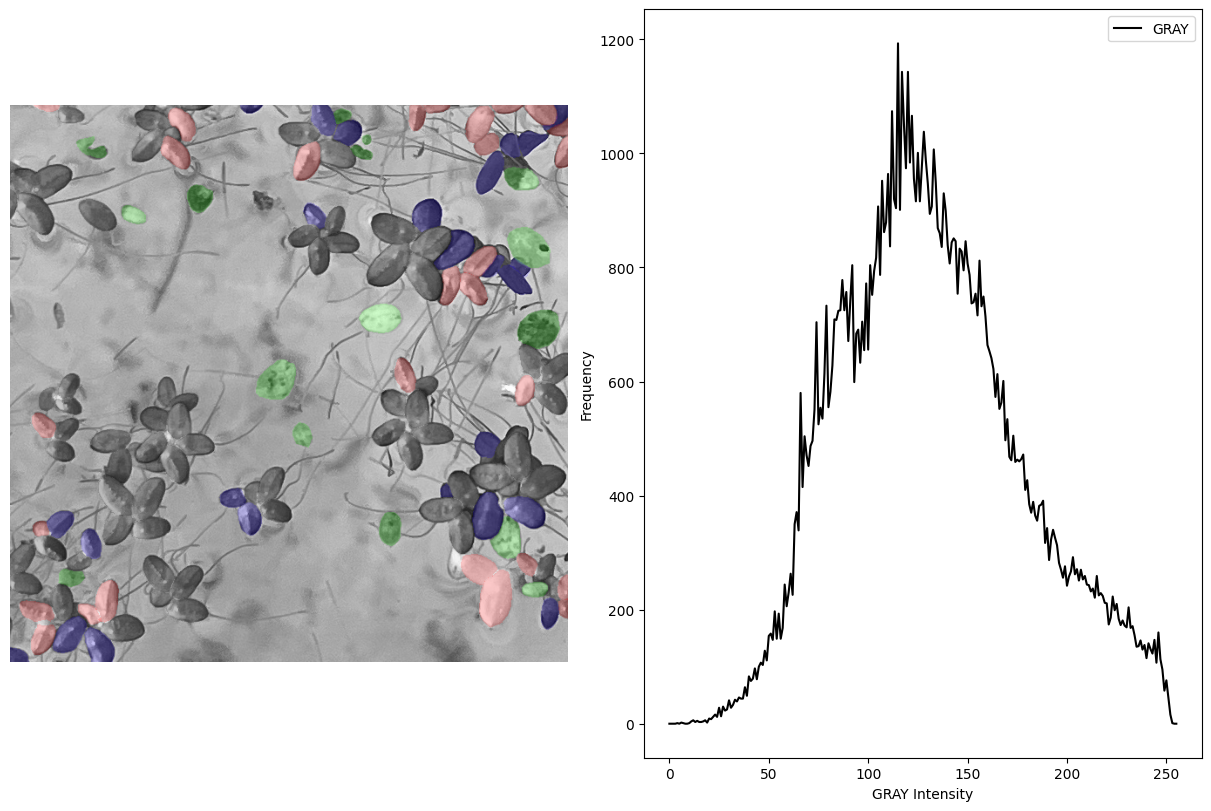

In [2]:
from scg_detection_tools.utils.file_handling import get_all_files_from_paths

IMG_DIR = "/home/julio/Dev/SCG_IFSC/save/light_group_annotations/images"
LBL_DIR = "/home/julio/Dev/SCG_IFSC/save/light_group_annotations/labels"

IMG_DIR = "/home/julio/Dev/SCG_IFSC/save/light_group_annotations/images"
imgs = get_all_files_from_paths(IMG_DIR)
LBL_DIR = "/home/julio/Dev/SCG_IFSC/save/light_group_annotations/labels"


#IMG_DIR = "/home/julio/Dev/SCG_IFSC/save/hemacias"
#imgs = get_all_files_from_paths(IMG_DIR)


img_hists = analyze_color_histogram(model=model, detector=det, imgs=imgs, raw=False, on_detection_boxes=False, seg_annotations=LBL_DIR, cspaces=["RGB", "HSV", "GRAY"], show=True, save_plots=False)


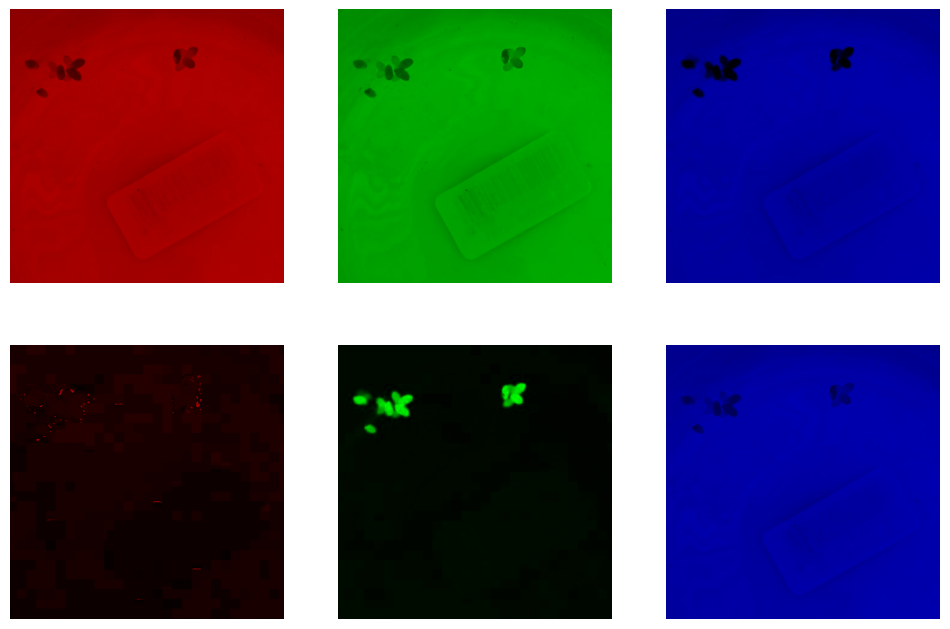

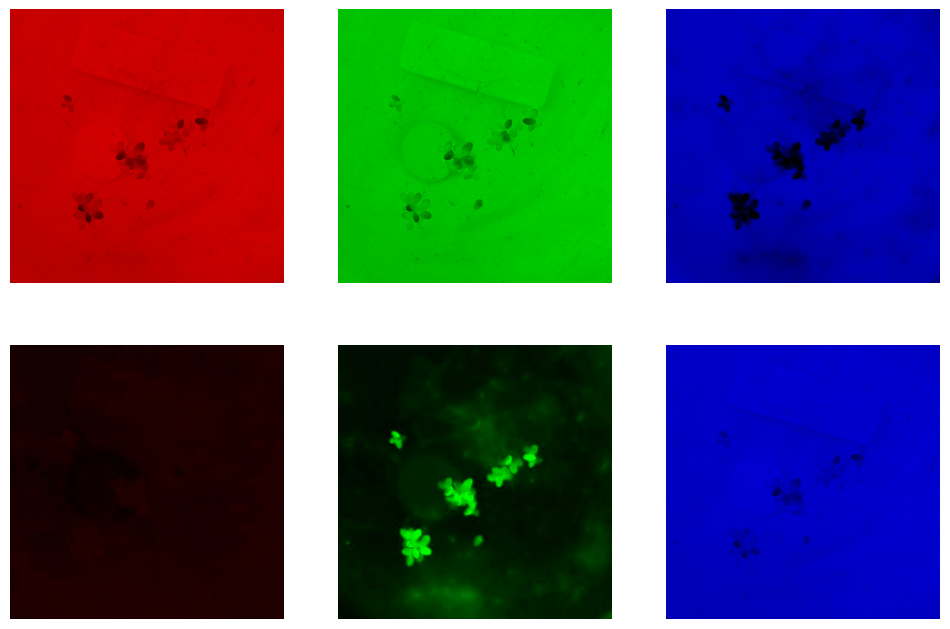

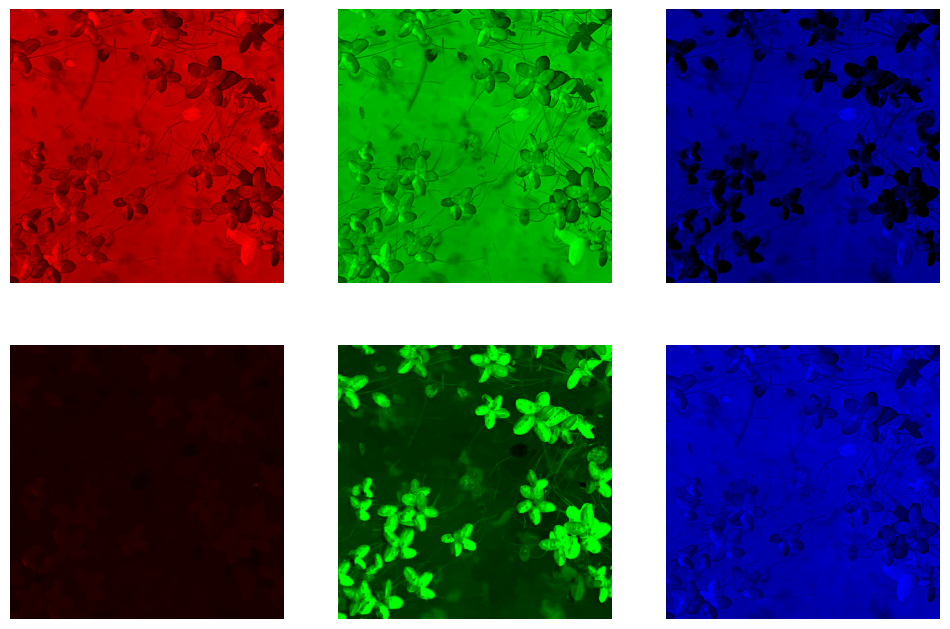

In [6]:
import os
for img in imgs:
    fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(12,8))
    
    rgb = cv2.imread(img)
    rgb = cv2.cvtColor(rgb, cv2.COLOR_BGR2RGB)
    hsv = cv2.cvtColor(rgb.copy(), cv2.COLOR_RGB2HSV)

    for ci, cp in enumerate([rgb, hsv]):
        for i in range(3):
            ch = cp.copy()
            for j in range(3):
                if i != j:
                    ch[:,:,j] = 0
            axs[ci][i].axis("off")
            axs[ci][i].imshow(ch)
    fig.savefig(f"exp_analysis/singlechannel_{os.path.basename(img)}")
    plt.show()

          R Mean    G Mean    B Mean     R std     G std     B std
R Mean  1.000000  0.948597  0.828654 -0.046495 -0.045118  0.119512
G Mean  0.948597  1.000000  0.702156 -0.009500 -0.000902  0.213239
B Mean  0.828654  0.702156  1.000000  0.034077  0.012700  0.149229
R std  -0.046495 -0.009500  0.034077  1.000000  0.984426  0.808100
G std  -0.045118 -0.000902  0.012700  0.984426  1.000000  0.784983
B std   0.119512  0.213239  0.149229  0.808100  0.784983  1.000000
          H Mean    S Mean    V Mean     H std     S std     V std
H Mean  1.000000  0.609842 -0.156501  0.026564  0.587038  0.126537
S Mean  0.609842  1.000000 -0.624319 -0.161919  0.438028  0.057641
V Mean -0.156501 -0.624319  1.000000 -0.008554 -0.307685  0.012563
H std   0.026564 -0.161919 -0.008554  1.000000  0.443920  0.639492
S std   0.587038  0.438028 -0.307685  0.443920  1.000000  0.600757
V std   0.126537  0.057641  0.012563  0.639492  0.600757  1.000000
           Gray mean  Gray std
Gray mean   1.000000  0.003576


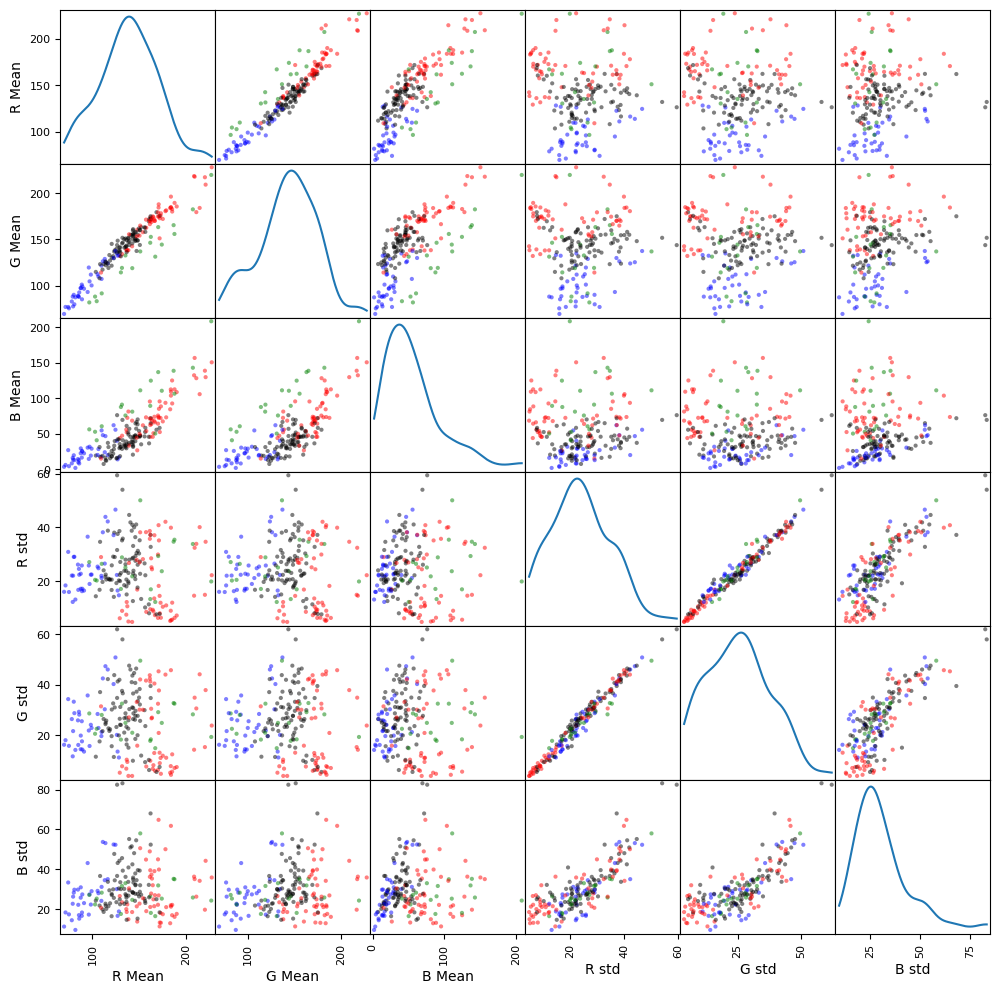

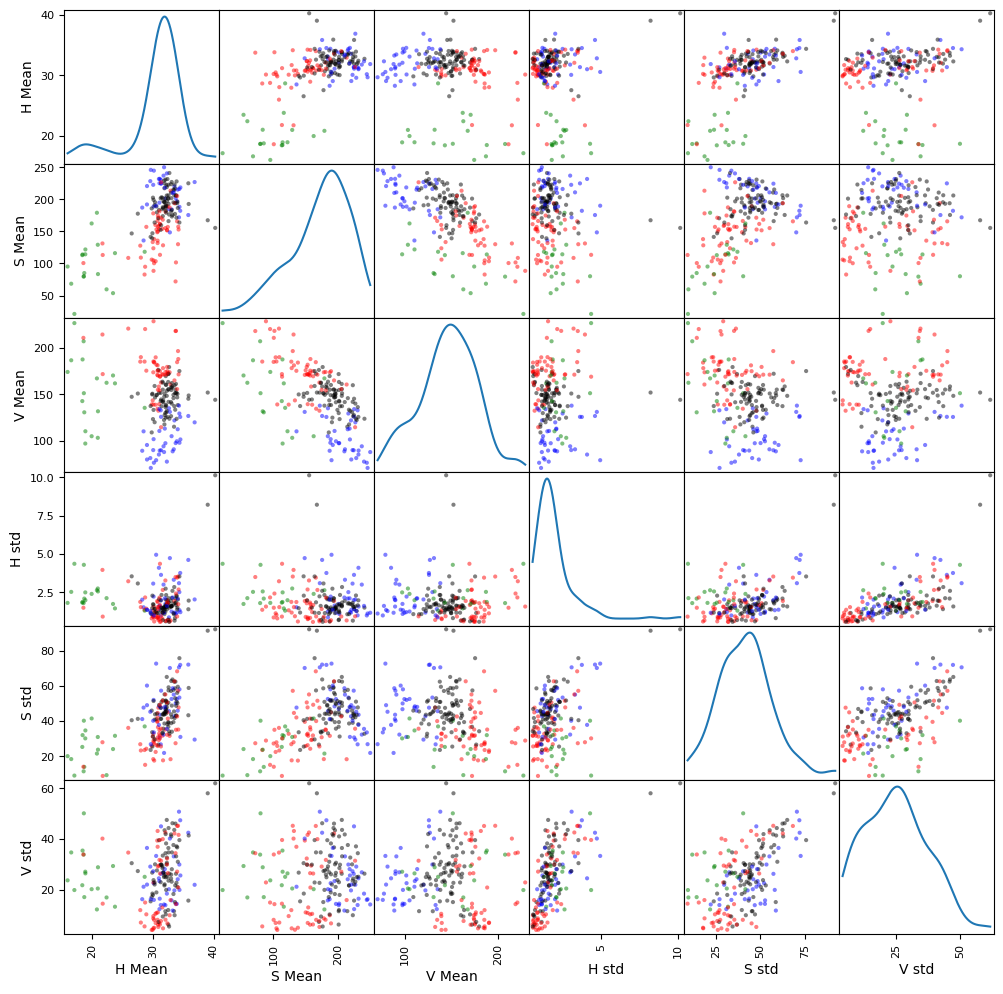

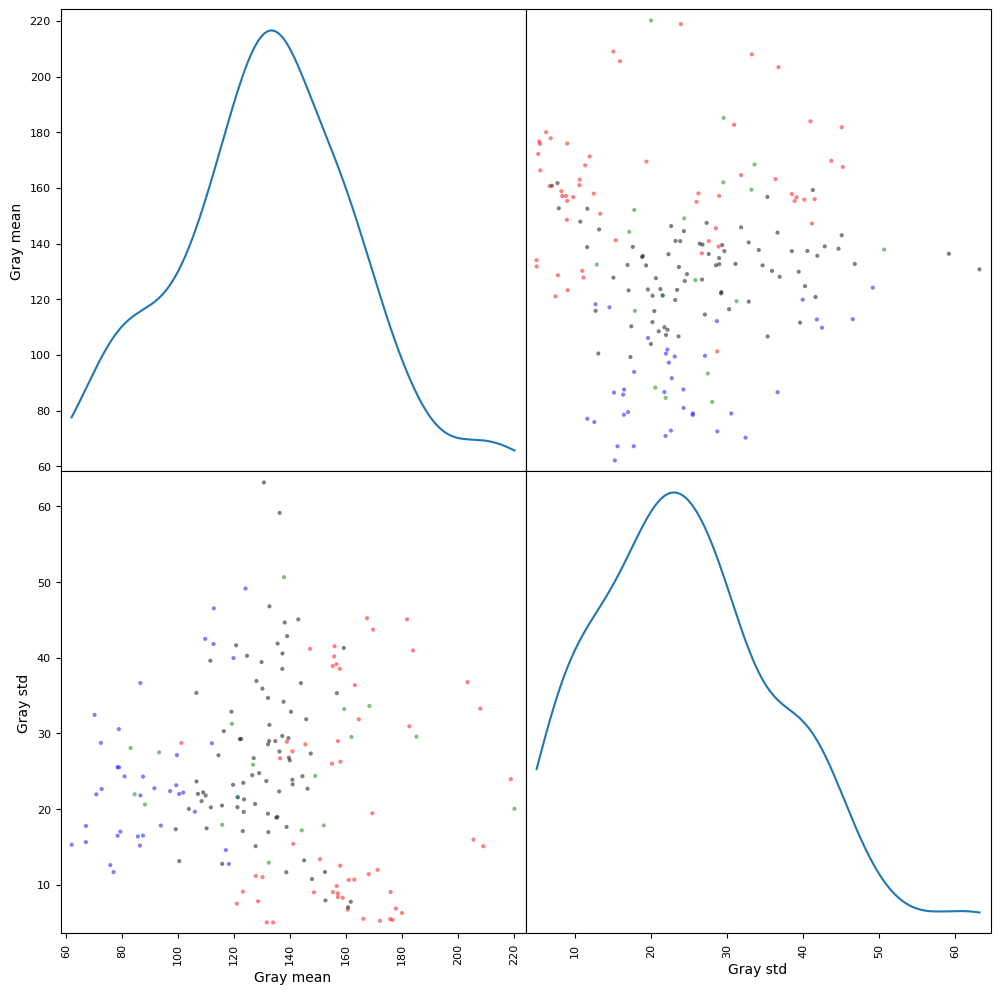

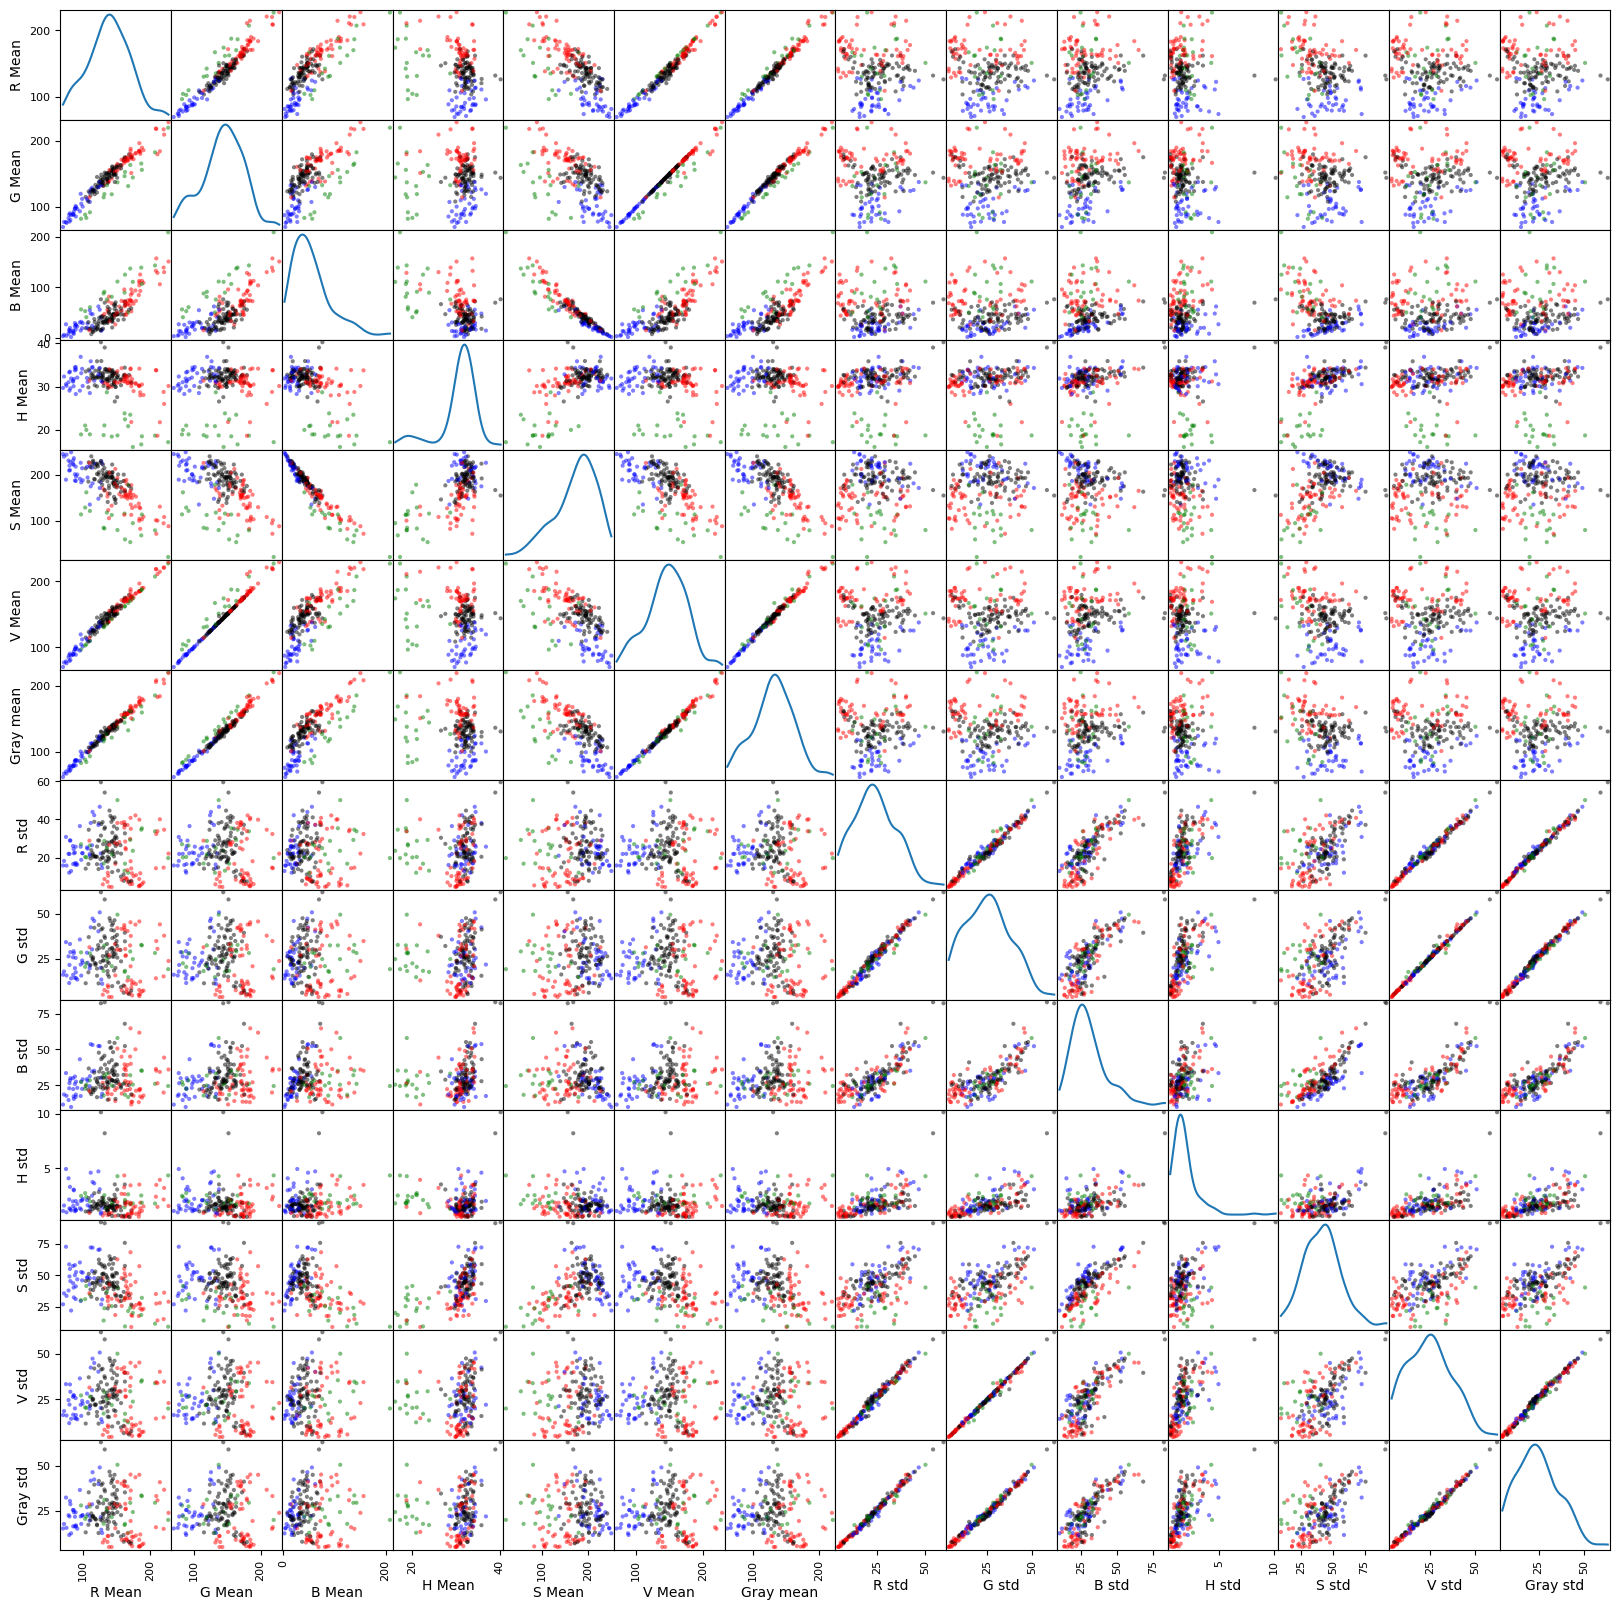

In [7]:
cspaceAnalysis = {"RGB": [], "HSV": [], "GRAY": [], "ALL": []}
nclass = {0: "light", 1: "medium", 2: "dark", 3: "dead"}
intensities = np.arange(256)

for img in img_hists:
    img_hist = img_hists[img]
    for cspace in ["RGB", "HSV", "GRAY"]:
        for mask_hist in img_hist[cspace]["masks"]:
            hist = mask_hist["hist"]
            mask_class = nclass[mask_hist["class"]]

            ch_stats = []
            for ch_hist in hist:
                ch_mean = np.sum(intensities * ch_hist) / np.sum(ch_hist)
                ch_std = np.sqrt(np.sum((intensities - ch_mean) ** 2 * ch_hist) / np.sum(ch_hist))
                ch_stats.append([ch_mean, ch_std])
            
            ch_stats = np.array(ch_stats).T.ravel().tolist()
            ch_stats.append(mask_class)
            cspaceAnalysis[cspace].append(ch_stats)


num_masks = len(cspaceAnalysis["RGB"])
all_mean = []
all_std = []
all_class = [data[-1] for data in cspaceAnalysis["RGB"]]

for maskidx in range(num_masks):
    all_mean.append([])
    all_std.append([])
    for cspace in ["RGB", "HSV", "GRAY"]:
        data = cspaceAnalysis[cspace][maskidx]
        if cspace == "GRAY":
            ch_mean = data[0]
            ch_std = data[1]
            all_mean[-1].append(ch_mean)
            all_std[-1].append(ch_std)
        else:
            ch_mean = data[:3]
            ch_std = data[3:-1]
            all_mean[-1].extend(ch_mean)
            all_std[-1].extend(ch_std)
for i in range(num_masks):
    cspaceAnalysis["ALL"].append([])
    
    cspaceAnalysis["ALL"][i].extend(all_mean[i])
    cspaceAnalysis["ALL"][i].extend(all_std[i])
    cspaceAnalysis["ALL"][i].append(all_class[i])

rgbdf = pd.DataFrame(cspaceAnalysis["RGB"], columns=[
    "R Mean", "G Mean", "B Mean", "R std", "G std", "B std", "Class"
])
hsvdf = pd.DataFrame(cspaceAnalysis["HSV"], columns=[
    "H Mean", "S Mean", "V Mean", "H std", "S std", "V std", "Class"
])
graydf = pd.DataFrame(cspaceAnalysis["GRAY"], columns=[
    "Gray mean", "Gray std", "Class"
])

alldf = pd.DataFrame(cspaceAnalysis["ALL"], columns=[
    "R Mean", "G Mean", "B Mean", "H Mean", "S Mean", "V Mean", "Gray mean", "R std", "G std", "B std", "H std", "S std", "V std", "Gray std", "Class"
])

class_color = lambda df: df["Class"].map({
    "light": "b", 
    "medium": "g", 
    "dark": "r", 
    "dead": "k"
})

scatter_matrix(rgbdf.iloc[:,:-1], figsize=(12,12), diagonal="kde", c=class_color(rgbdf))
scatter_matrix(hsvdf.iloc[:,:-1], figsize=(12,12), diagonal="kde", c=class_color(hsvdf))
scatter_matrix(graydf.iloc[:,:-1], figsize=(12,12), diagonal="kde", c=class_color(graydf))
scatter_matrix(alldf.iloc[:,:-1], figsize=(20,20), diagonal="kde", c=class_color(alldf))

print(rgbdf.corr(numeric_only=True))
print(hsvdf.corr(numeric_only=True))
print(graydf.corr(numeric_only=True))

In [ ]:
print(len(img_hists[imgs[0]]["RGB"]["masks"]))

# Pixel density

In [ ]:
from analyze import analyze_pixel_density

IMG_DIR = "/home/julio/Dev/SCG_IFSC/scg-leaf-count/imgs/test"
LBL_DIR = "/home/julio/Dev/SCG_IFSC/scg-leaf-count/imgs/testlabels"

imgs = [
    f"{IMG_DIR}/e1.png",
    f"{IMG_DIR}/e3.png",
    f"{IMG_DIR}/e4.png",
]

densities = analyze_pixel_density(model=model, 
                                  detector=det, 
                                  imgs=imgs, 
                                  cfg=cfg, 
                                  on_slice=False, 
                                  on_detection_boxes=False,
                                  on_crops=True,
                                  seg_annotations=None, 
                                  save_detections=False)
print(densities)